# Named Entity Recognition with BERT

<div style="width:image width px; font-size:100%; text-align:center;"><img src='https://github.com/braydonwang/Natural-Language-Processing-Assignments/blob/main/Week3/bert_ner.jpg' alt="alternate text" width="width" height="height" style="width:600px;height:250px;" /></div>

The process of pretraining and finetuning in natural language processing (NLP) have increased in the last few years. Large neural networks have been trained on general tasks like language modeling and then fine-tuned for classification tasks. One of the latest milestones in this development is the release of the Bidirectional Encoder Representations from Transformers (BERT) model. BERT is a Transformer-based model that broke several records for how well models can handle language-based tasks. 

For this task, we will apply the concept of transfer learning to named entity recognition (NER). Concretely, we will fine tune a pre-trained BERT model to perform state-of-the-art (SOTA) NER.

### Note:
For this task you need to setup the GPU inside this google collab notebook. For that use the following instructions:

`Runtime` > `Change runtime type` > Choose `GPU` under `Hardware accelerator`'s dropdown menu


Then, first we install the transformers package by huggingface using the following command:

In [5]:
!pip install transformers==2.6.0

In [6]:
import transformers
transformers.__version__

'2.6.0'

Now you have access to many transformer-based models including the pre-trained BERT models in pytorch.

## Load the data

For this task we will use the Annotated Corpus for Named Entity Recognition dataset from Kaggle, which you can find [here](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus#ner_dataset.csv).

Please download the file `ner_dataset.csv` and upload it into the session storage

In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

data = pd.read_csv("ner_dataset.csv", encoding="latin1").fillna(method="ffill")
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [8]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [9]:
getter = SentenceGetter(data)

This is how the sentences in the dataset look like.

In [10]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

The sentences are annotated with the BIO-schema and the labels look like this.

In [11]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
labels[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-gpe',
 'O',
 'O',
 'O',
 'O',
 'O']

In [12]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [13]:
print(tag2idx)

{'B-art': 0, 'B-tim': 1, 'B-gpe': 2, 'I-gpe': 3, 'I-tim': 4, 'I-nat': 5, 'I-per': 6, 'O': 7, 'I-art': 8, 'B-geo': 9, 'I-org': 10, 'B-per': 11, 'B-nat': 12, 'I-geo': 13, 'I-eve': 14, 'B-org': 15, 'B-eve': 16, 'PAD': 17}


## Apply BERT

### Prepare the sentences and labels

Before we can start fine-tuning the model, we have to prepare the data set for the use with pytorch and BERT.

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.9.0+cu102'

Here we fix some configurations. We will limit our sequence length to 75 tokens and we will use a batch size of 32 as suggested by the BERT paper. Note, that BERT supports sequences of up to 512 tokens.

In [15]:
MAX_LEN = 75
BATCH_SIZE = 32

In [16]:
# To set GPU: Runtime > Change runtime type > Choose GPU under Hardware accelerator dropdown menu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [17]:
n_gpu

1

In [18]:
torch.cuda.get_device_name(0)

'Tesla K80'

The BERT implementation comes with a pretrained tokenizer and a definied vocabulary. We load the one related to the smallest pre-trained model `bert-base-cased`. We use the `cased` variate since it is well suited for NER.

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Now we tokenize all sentences. Since the BERT tokenizer is based on a [Wordpiece tokenizer](https://paperswithcode.com/method/wordpiece) it will split tokens in subword tokens. For example 'gunships' will be split in the two tokens 'guns' and '##hips'. We have to deal with the issue of splitting our token-level labels to related subtokens. In practice you would solve this by a specialized data structure based on label spans, but for simplicity we will just use the following:



In [20]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [21]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [22]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

Next, we cut and pad the token and label sequences to our desired length.

In [23]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [24]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

Now, if you remember, the BERT model supports something called `attention_mask`, which is similar to the masking in Keras. So here we create the mask to ignore the padded elements in the sequences.

In [25]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

Now we split the dataset to use 10% to validate the model.

In [26]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=45, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=45, test_size=0.1)

Since we’re operating in pytorch, we have to convert the dataset to torch tensors.

In [27]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

The last step is to define the dataloaders. We shuffle the data at training time with the `RandomSampler` and at test time we just pass them sequentially with the `SequentialSampler`.

In [28]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

### Setup the BERT model for finetuning

The `transformer` package provides a `BertForTokenClassification` class for token-level predictions. `BertForTokenClassification` is a fine-tuning model that wraps `BertModel` and adds token-level classifier on top of the `BertModel`. The token-level classifier is a linear layer that takes as input the last hidden state of the sequence. We load the pre-trained `bert-base-cased` model and provide the number of possible labels.

In [29]:
from transformers import BertForTokenClassification, AdamW

In [30]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Now we have to pass the model parameters to the GPU.

In [31]:
model.cuda();

Before we can start the fine-tuning process, we have to setup the optimizer and add the parameters it should update. A common choice is the `AdamW` optimizer. We also add some `weight_decay` as regularization to the main weight matrices. If you have limited resources, you can also try to just train the linear classifier on top of BERT and keep all other weights fixed. This will still give you a good performance.

In [32]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

We also add a scheduler to linearly reduce the learning rate throughout the epochs.

In [33]:
from transformers import get_linear_schedule_with_warmup

epochs = 4
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

### Fit BERT for NER

First we define some metrics, we want to track while training. We use the `f1_score` from the seqeval package and we use simple accuracy on a token level comparable to the accuracy in keras.

In [34]:
!pip install seqeval

     |████████████████████████████████| 43 kB 1.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=00fe09b1939d00754bfbc91d27340a1d1bde0a42c11b941b1bd28d4b3d1585b9
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [35]:
from seqeval.metrics import f1_score, accuracy_score

In [37]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    print()

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Average train loss: 0.07954672143191895
Validation loss: 0.1346915728598833
Validation Accuracy: 0.9614105785096556


Epoch:  25%|██▌       | 1/4 [19:17<57:52, 1157.46s/it]

Validation F1-Score: 0.8297168522958333

Average train loss: 0.061115158297911316
Validation loss: 0.14306227830549081
Validation Accuracy: 0.962090495261312


Epoch:  50%|█████     | 2/4 [38:28<38:27, 1153.61s/it]

Validation F1-Score: 0.8337868069411694

Average train loss: 0.0540826286819575
Validation loss: 0.14306227830549081
Validation Accuracy: 0.962090495261312


Epoch:  75%|███████▌  | 3/4 [57:40<19:12, 1152.73s/it]

Validation F1-Score: 0.8337868069411694

Average train loss: 0.05385191733289574
Validation loss: 0.14306227830549081
Validation Accuracy: 0.962090495261312


Epoch: 100%|██████████| 4/4 [1:16:50<00:00, 1152.72s/it]

Validation F1-Score: 0.8337868069411694



### Visualize the training loss

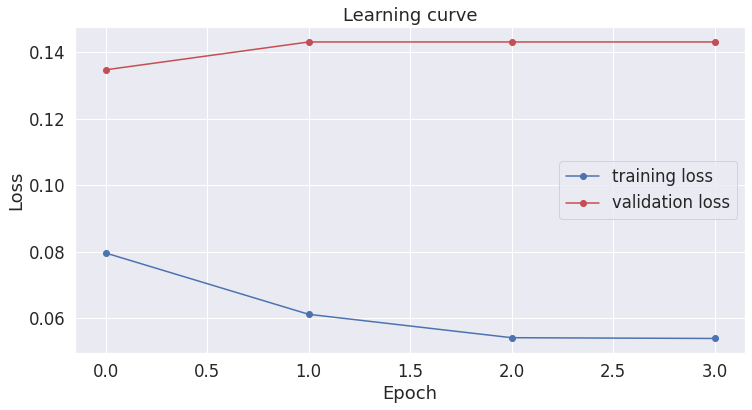

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

### Apply the model to a new sentence

Finally we want our model to identify named entities in new text.

In [39]:
test_sentence = """
The 2013 action movie Snowpiercer starring Chris Evans was shot in Vancouver, British Columbia, Canada.
"""

We first tokenize the text.

Notes: 
- Use the tokenizer `encode` method to tokenize the test sentence.
- For `input_ids` you only need to convert the tokenized_sentence to a torch tensor. Don't forget to pass the `input_ids` to GPU.

In [40]:
### START CODE HERE (Replace instanes of 'None' with your code) ###
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
### END CODE HERE ###

Then we can run the sentence through the model.

Notes:
- In `with` statement, use torch's [no_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html) method

In [41]:
### START CODE HERE (Replace instanes of 'None' with your code) ###
with torch.no_grad():
    # Pass input_ids to trained model for getting the output
    output = model(input_ids)

# use numpy's argmax method to return the indices of the maximum values of output[0] along the correct axis
# hint: when you move output to('cpu') you need to convert the tensor object into a numpy.ndarray object
label_indices = np.argmax(output[0].to('cpu').numpy(),axis=2)
### END CODE HERE ###

Now we will implement code to join the split tokens

In [42]:
### START CODE HERE (Replace instanes of 'None' with your code) ###
# try to figure out which tokenizer method to use here to convert ids into tokens
# hint: when you move input_ids to('cpu') you need to convert the tensor object into an numpy.ndarray object
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
# assign the new_tokens and new_labels variables each with an empty list
new_tokens, new_labels = [], []
# loop over tokens and label_indices[0]
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        # modify last token in new_tokens to include current token
        # hint: you don't need to include the `##`
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        # append tag_values at label_idx into new_labels
        new_labels.append(tag_values[label_idx])
        # append token into new_tokens
        new_tokens.append(token)
### END CODE HERE ###

In [43]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	The
B-tim	2013
O	action
O	movie
O	Snowpiercer
O	starring
B-per	Chris
I-per	Evans
O	was
O	shot
O	in
B-geo	Vancouver
O	,
B-geo	British
B-geo	Columbia
O	,
B-geo	Canada
O	.
O	[SEP]


As you can see, this works very well! This approach will give you very strong performing models for NER. Since BERT is available as a multilingual model in 102 languages, you can use it for a wide variety of tasks.